# Dataset
The images are from [Unsplash](https://unsplash.com) - creative commons pictures by professional photographers. It includes 9.5 thousand training images and 500 validation images.

In [1]:
# keras layers
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization

# keras tensorboard
from keras.callbacks import TensorBoard

# keras model
from keras.models import Sequential

# keras preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# skimage
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave, imshow

# others
import numpy as np
import os
import random
import tensorflow as tf

/home/saucecat/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Get images

In [2]:
X = []
for filename in os.listdir('../Full-version/Train/'):
    X.append(img_to_array(load_img('../Full-version/Train/' + filename)))
X = np.array(X, dtype=float)

print X.shape

(10, 256, 256, 3)


# Prepare  train and test data

In [3]:
split = int(0.95 * len(X))
Xtrain = X[:split]
Xtrain = 1.0 / 255 * Xtrain

# Build the model

<img src='images/flow_01.png', width=600>
<center><b>Number of filters</b></center>

<img src='images/flow_02.png', width=500>
<center><b>2D dimension view</b></center>

In [4]:
model = Sequential()
# (256, 256, 1)
model.add(InputLayer(input_shape=(256, 256, 1)))
# (256, 256, 64)
model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) 
# (128, 128, 64)
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
# (64, 64, 64)
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# (64, 64, 128)
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
# (32, 32, 128)
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# (32, 32, 256)
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
# (32, 32, 512)
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# (32, 32, 256)
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# (32, 32, 128)
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# (64, 64, 128)
model.add(UpSampling2D((2, 2)))
# (64, 64, 64)
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# (128, 128, 64)
model.add(UpSampling2D((2, 2)))
# (128, 128, 32)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# (128, 128, 2)
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
# (256, 256, 2)
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse')

<img src="images/explain_01.png" width=700>

The main difference from other visual networks is the importance of **pixel location**. In coloring networks, the image size or ratio stays the same throughout the network. In other networks, the image gets distorted the closer it gets to the final layer.  

The **max-pooling** layers in classification networks increase the information density, but also distort the image. It only values the information, but not the layout of an image. In coloring networks we instead use a stride of 2, to decrease the width and height by half. This also increases information density but does not distort the image.

# Image transformer (data augmentation)

In [5]:
datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, rotation_range=20, horizontal_flip=True)

# Generate training data

In [28]:
batch_size = 50
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:, :, :, 0]
        Y_batch = lab_batch[:, :, :, 1:] / 128
        yield (X_batch.reshape(X_batch.shape + (1,)), Y_batch)

# Train model

In [29]:
tensorboard = TensorBoard(log_dir='output/first_run')
model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard], epochs=1, steps_per_epoch=1000)

Epoch 1/1
1000/1000 [==============================] - 301s 301ms/step - loss: 0.0023


# Save model

In [30]:
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5')

# Test images

In [31]:
Xtest = rgb2lab(1.0 / 255 * X[split:])[:, :, :, 0]
Xtest = Xtest.reshape(Xtest.shape + (1,))
Ytest = rgb2lab(1.0 / 255 * X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(model.evaluate(Xtest, Ytest, batch_size=batch_size))

1/1 [==============================] - 0s 7ms/step
0.011155663058161736


# Display the prediction

In [32]:
Ypred = model.predict(Xtest) * 128
print Ypred.shape

(1, 256, 256, 2)


In [33]:
import matplotlib.pyplot as plt

def get_pred(X, pred):
    cur = np.zeros(pred.shape[1:3] + (3,))
    cur[:, :, 0] = X[0][:, :, 0]
    cur[:, :, 1:] = pred[0]
    return cur

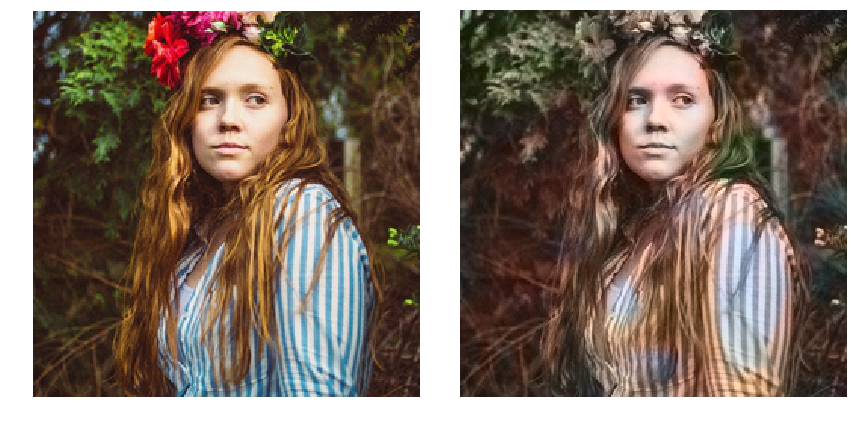

In [34]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
imshow(1.0 / 255 * X[split:][0])
plt.axis('off')
plt.subplot(1, 2, 2)
imshow(lab2rgb(get_pred(Xtest, Ypred)))
plt.axis('off')
plt.show()

# Test around and output colorizations

In [35]:
color_me = []
for filename in os.listdir('../Full-version/Test/'):
    color_me.append(img_to_array(load_img('../Full-version/Test/' + filename)))
color_me = np.array(color_me, dtype=float)
color_me_raw = color_me
color_me = rgb2lab(1.0 / 255 * color_me)[:, :, :, 0]
color_me = color_me.reshape(color_me.shape + (1,))

print color_me.shape

(8, 256, 256, 1)


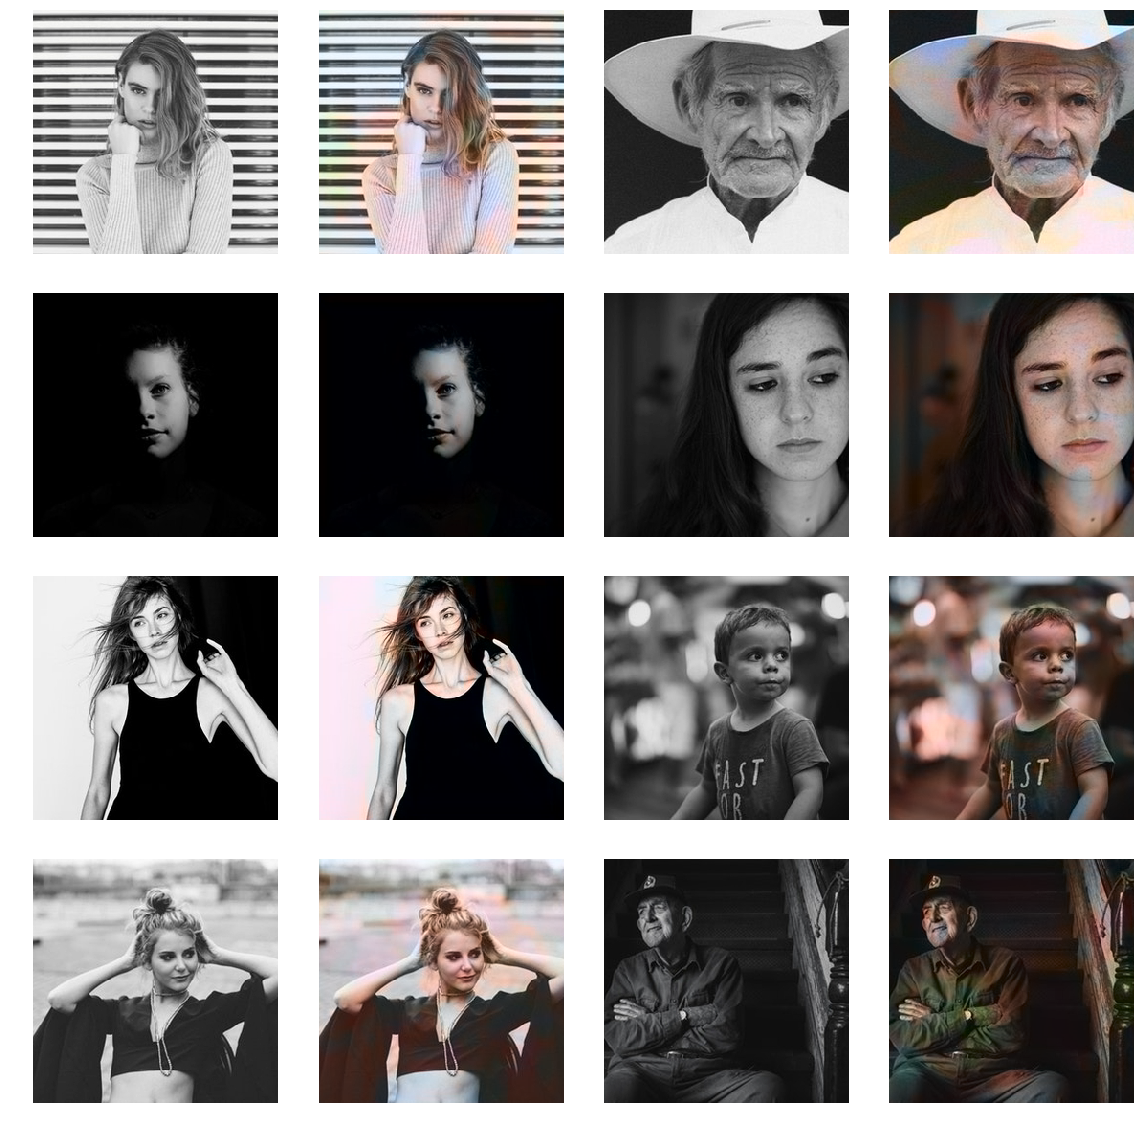

In [36]:
output = model.predict(color_me)
output = output * 128

plt.figure(figsize=(16, 16))

for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:, :, 0] = color_me[i][:, :, 0]
    cur[:, :, 1:] = output[i]
    plt.subplot(4, 4, i*2+1)
    imshow(1.0 / 255 * color_me_raw[i])
    plt.axis('off')
    plt.subplot(4, 4, i*2+2)
    imshow(lab2rgb(cur))
    plt.axis('off')
plt.show()

# Understand the Beta version
Because most of the training data is quite similar, the network struggles to differentiate between different objects. It will adjust different tones of brown, but fail to generate more nuanced colors. That’s what we’ll explore in the full version.